# Covariates - Wage Mass

In this notebook, we'll analyze and try to model the behavior of the `Wage Mass` variable, that'll be used as an explanatory variable to our final model.

In [6]:
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf
import pandas as pd

from utils import get_filtered_data, create_future_dataframe, plot_series

In [2]:
#Reading the data
df = get_filtered_data()

## Visualizing the Data

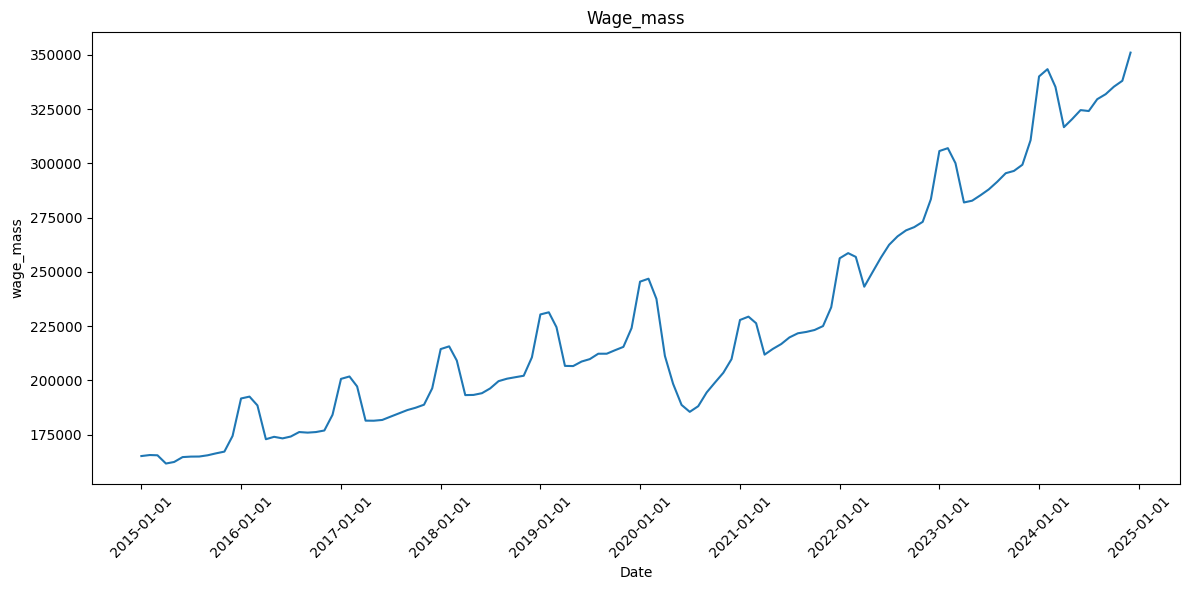

In [3]:
wage_mass = df[['date', 'wage_mass']] 
plot_series(wage_mass, 'wage_mass')

We can see a clear probably yearly seasonality and an increasing trend. 
We can also see a strucutural change around 2020, that marks a sharp decrease followed by an increasing rise of the slope. 

## Linear Model with Knot

In [15]:
#adding the month and t varibles to indicate the seasnality

wage_mass = (
    wage_mass
    .assign(
        t = range(len(wage_mass)),
        month = wage_mass["date"].dt.month
    )
)

#defining the knot date 
knot_date = pd.to_datetime("2020-05-01")

wage_mass["t_knot"] = (wage_mass["date"] >= knot_date).astype(int) * (wage_mass["t"] - wage_mass.loc[wage_mass["date"] == knot_date, "t"].iloc[0]) 

#Model Fitting
model_wage_mass = smf.ols("wage_mass ~ t + t_knot + C(month)", data=wage_mass).fit()

In [16]:
wage_mass['fitted'] = model_wage_mass.fittedvalues
model_wage_mass.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wage_mass   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     179.0
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           8.64e-66
Time:                        15:19:56   Log-Likelihood:                -1284.2
No. Observations:                 120   AIC:                             2596.
Df Residuals:                     106   BIC:                             2635.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        1.87e+05   4299.751     43.484      0.000    1.78e+05    1.95e+05
C(month)[T.2]    160.7814   5117.070      0.031      0.975   -9984.308    1.03e+04
C(month)[T.3]  -6275.9372   5117.347     -1.226      0.223   -1.64e+04    3869.702
C(month)[T.4]  -2.358e+04   5117.810     -4.608      0.000   -3.37e+04   -1.34e+04
C(month)[T.5]  -2.461e+04   5118.457     -4.809      0.000   -3.48e+04   -1.45e+04
C(month)[T.6]  -2.501e+04   5119.241     -4.885      0.000   -3.52e+04   -1.49e+04
C(month)[T.7]   -2.51e+04   5120.212     -4.902      0.000   -3.53e+04   -1.49e+04
C(month)[T.8]  -2.389e+04   5121.373     -4.665      0.000    -3.4e+04   -1.37e+04
C(month)[T.9]  -2.347e+04   5122.721     -4.582      0.000   -3.36e+04   -1.33e+04
C(month)[T.10] -2.336e+04   5124.258     -4.559      0.000   -3.35e+04   -1.32e+04
C(month)[T.11] -2.288e+04   5125.982     -4.464      0.000    -3.3e+04   -1.27e+04
C(month)[T.12] -1.547e+04   5127.894     -3.017      0.003   -2.56e+04   -5304.577
t                605.8353     61.885      9.790      0.000     483.142     728.529
t_knot          1741.4582    121.636     14.317      0.000    1500.303    1982.613
==============================================================================
Omnibus:                        4.612   Durbin-Watson:                   0.079
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                3.762
Skew:                          -0.327   Prob(JB):                        0.152
Kurtosis:                       2.430   Cond. No.                         890.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Visualizing the Fit on Training Data

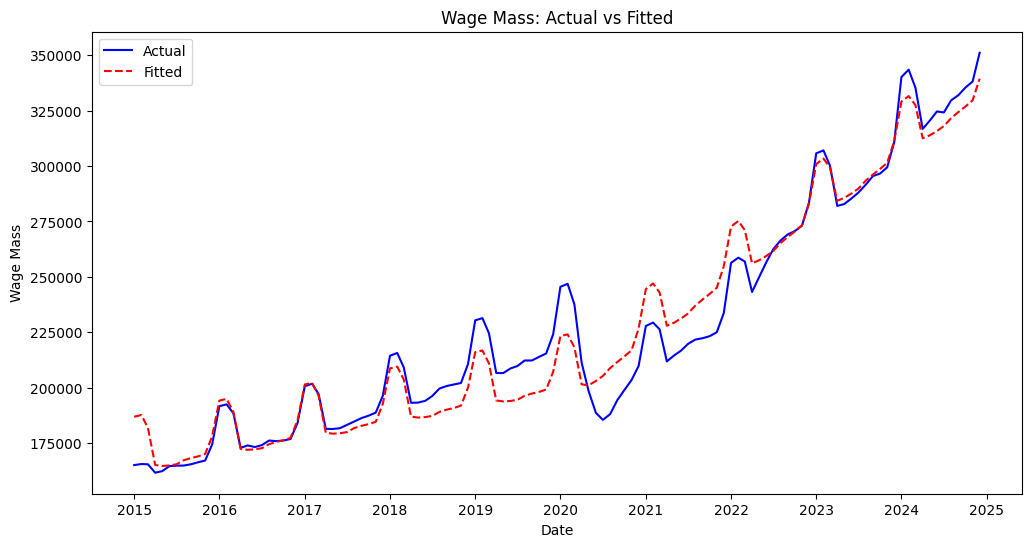

In [18]:
wage_mass['fitted'] = model_wage_mass.fittedvalues

# Plot actual vs fitted
plt.figure(figsize=(12, 6))
plt.plot(wage_mass["date"], wage_mass["wage_mass"], label="Actual", color="blue")
plt.plot(wage_mass["date"], wage_mass["fitted"], label="Fitted", color="red", linestyle="--")

plt.title("Wage Mass: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Wage Mass")
plt.legend()
plt.show()

Once again, we got a preety good model just using a simple Linear Regression model. 

As we can see just with the trend and the seasonal dummy varibles we get an $R-Squared = 0.95$


### Visualizing the Predictions on the Test Set

In [31]:
test_df = create_future_dataframe() 

display(test_df.head())

t_knot_index = wage_mass.loc[wage_mass["date"] == knot_date, "t"].iloc[0] # where the knot happens

test_df["t_knot"] = (test_df["date"] >= knot_date).astype(int) * (test_df["t"] - t_knot_index)


,date,t,month
0,2025-01-01,120,1
1,2025-02-01,121,2
2,2025-03-01,122,3
3,2025-04-01,123,4
4,2025-05-01,124,5


In [32]:
wage_mass_preds = model_wage_mass.predict(test_df)
test_df['wage_mass'] = wage_mass_preds

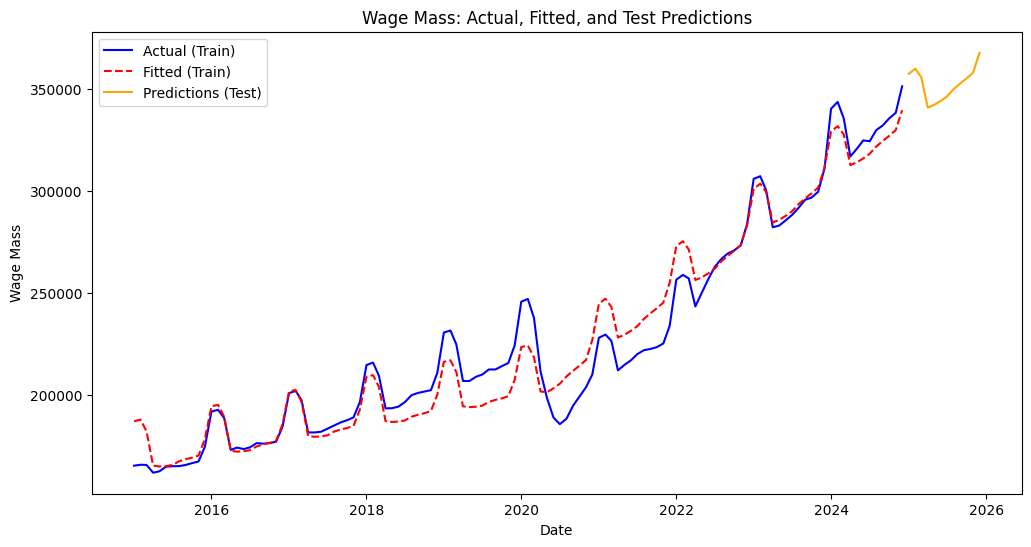

In [37]:
# Plot
plt.figure(figsize=(12, 6))

# Actual (train only)
plt.plot(wage_mass["date"], wage_mass["wage_mass"],
         label="Actual (Train)", color="blue") 

# Fitted (train only)
plt.plot(wage_mass["date"], wage_mass["fitted"],
         label="Fitted (Train)", color="red", linestyle="--")

# Predictions (test only)
plt.plot(test_df["date"], test_df["wage_mass"],
         label="Predictions (Test)", color="orange")

plt.title("Wage Mass: Actual, Fitted, and Test Predictions")
plt.xlabel("Date")
plt.ylabel("Wage Mass")
plt.legend()
plt.show()

## Saving the Wage Predictions

In [39]:
test_df[['date', 'wage_mass']].to_csv("../../predictions/2025_wage_mass.csv", index=False)

In [40]:
test_df[['date', 'wage_mass']]

,date,wage_mass
0,2025-01-01,357190.526406
1,2025-02-01,359698.601339
2,2025-03-01,355609.176271
3,2025-04-01,340650.451204
4,2025-05-01,341965.726136
5,2025-06-01,343917.155247
6,2025-07-01,346175.084357
7,2025-08-01,349731.913468
8,2025-09-01,352497.742578
9,2025-10-01,354953.371689
